<a href="https://colab.research.google.com/github/gibsonx/tf_skeleton/blob/master/tf_keypoint_colab_densenet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!git clone https://github.com/gibsonx/tf_skeleton.git

In [ ]:
#!pip install -r /content/tf_skeleton/requirements.txt > /dev/null

In [ ]:
from pycocotools.coco import COCO
import numpy as np
np.bool=bool
import os.path
from typing import Any, Callable, List, Optional, Tuple
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, json, cv2, numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras

import tensorflow as tf
print(tf.__version__)

from keras.models import Sequential,Model

from keras.layers import (
    Flatten,
    Dense,
    Dropout,
    Conv2D,
    LeakyReLU,
    BatchNormalization,
    MaxPool2D,
    GlobalAveragePooling2D,
)
from imgaug import augmenters as iaa
import imgaug as ia
import imageio
from keras.applications import ResNet50
from keras.applications.densenet import DenseNet121
from imgaug.augmentables.kps import Keypoint, KeypointsOnImage
import math

2.17.1


In [ ]:
train_img_dir="/content/drive/MyDrive/Dataset/aspine20230930/image_train"
val_img_dir="/content/drive/MyDrive/Dataset/aspine20230930/image_val"
val_annotations_file="/content/drive/MyDrive/Dataset/aspine20230930/annotations/person_keypoints_Validation.json"
train_annotations_file="/content/drive/MyDrive/Dataset/aspine20230930/annotations/person_keypoints_Train.json"

In [ ]:
class DataframeMaker():

  def __init__(self,img_path,annotations_file, img_height, img_width):
      self.img_path = img_path
      self.coco = COCO(annotations_file)
      self.imgIds = self.coco.getImgIds()
      self.dataframe = None
      self.__coco_build__()
      self.img_height = img_height
      self.img_width = img_width
      if self.img_width and self.img_height:
          self.resize_dataset()
          print ("image size has been set to %d x %d" % (self.img_height, self.img_width))
      else:
          print ("image keeps as original size")

  def __coco_build__(self):
      """
      read annotation and build dataframe
      :return:
      """
      kps_metrix = []

      for id in self.imgIds:

        # load a image
        img = self.coco.loadImgs(id)[0]
        imgPath = img['file_name']

        ann=self.coco.loadAnns(self.coco.getAnnIds(imgIds=img['id']))

        keypoints_original = [[list(a) for a in zip(*[iter(ann[0]['keypoints'])]*3)]]

        kps_row = []
        for kp in keypoints_original:
            for el in kp:
                kps_row.extend(el[0:2])
        kps_row.append(imgPath)

        kps_metrix.append(kps_row)



      df = pd.DataFrame(kps_metrix)

      self.dataframe = df

  def resize_dataset(self):
    """
    :param img_height:
    :param img_width:
    :return:
    """
    ts_kps_metrix = []
    ts_image_list = []

    for index, row in self.dataframe.iterrows():


      image = row[-1:].item()
      fullImgPath = os.path.join(self.img_path,image)
      open_cv_image = np.array(Image.open(fullImgPath))

      annotations = row[:32]
      converted_keypoints = [list(a) for a in zip(*[iter(annotations)]*2)]

      kps = [Keypoint(x=coodination[0], y=coodination[1]) for coodination in converted_keypoints]
      kpsoi = KeypointsOnImage(kps, shape=open_cv_image.shape)

      ia.seed(1)

      seq = iaa.Sequential([
          iaa.Crop(px=(32, 32, 32, 32)),
          iaa.Resize({"height": self.img_height , "width": self.img_width})
      ])

      image_aug, kpsoi_aug = seq(image=open_cv_image, keypoints=kpsoi)

      ts_kps_row = []

      image_height, image_width = image_aug.shape[:2]

      for i in range(len(kpsoi_aug.keypoints)):
          after = kpsoi_aug.keypoints[i]
          x = max(0, min(after.x, image_width - 1))  # Clamp x between 0 and image_width - 1
          y = max(0, min(after.y, image_height - 1))  # Clamp y between 0 and image_height - 1
          ts_kps_row.extend([x, y])

      ts_kps_metrix.append(ts_kps_row)
      ts_image_list.append(image_aug)

    df = pd.DataFrame(ts_kps_metrix)

    df['image'] = ts_image_list

    self.dataframe = df

class DataGenerator(tf.keras.utils.Sequence):

  def __init__(self, dataframe, batch_size, arguement = False):
      self.df = dataframe
      self.batch_size = batch_size
      self.argument = arguement

  def __len__(self):
      return math.ceil(len(self.df) / self.batch_size)

  def __getitem__(self, idx):
      low = idx * self.batch_size
      # Cap upper bound at array length; the last batch may be smaller
      # if the total number of items is not a multiple of batch size.
      high = min(low + self.batch_size, len(self.df))
      images = self.df.loc[low:high,'image']
      annotations = self.df.loc[low:high,:31]

      if self.argument:
          return self.data_arguement(images, annotations)
      else:
          return np.stack(images), annotations.to_numpy()

  def on_epoch_end(self):
      print("shuffle")
      self.df = self.df.sample(frac=1, random_state=41).reset_index(drop=True)

  def data_arguement(self, images, annotations):

      ia.seed(3)
      seq = iaa.Sequential([
            iaa.Sometimes(
              0.5,
              iaa.SomeOf((1, 3), [
              iaa.Affine(
                  rotate=(-8,8)
                  ),
              iaa.LinearContrast((0.4, 1.2)),
              iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
              ])
            )
          ])

      images_aug, points_aug = seq(images=images, keypoints=self.kpslist_to_tuple(annotations))
      kps_list = self.kpstuple_to_list(points_aug)

      return np.stack(images_aug), np.stack(kps_list)

  def kpslist_to_tuple(self,annotations):
      kpstuple = []

      for index, row in annotations.iterrows():
          converted_keypoints = [list(a) for a in zip(*[iter(row)]*2)]
          kps = [Keypoint(x=coodination[0], y=coodination[1]) for coodination in converted_keypoints]
          kpstuple.append(kps)

      return kpstuple

  def kpstuple_to_list(self,kps_tuple):
      kpslist = []

      for kpsoi in kps_tuple:
          ts_kps_row = []
          for i in range(len(kpsoi)):
              # print(kpsoi_aug[i].is_out_of_image(image=images_aug[i]))
              ts_kps_row.extend([kpsoi[i].x,kpsoi[i].y])
          kpslist.append(ts_kps_row)

      return kpslist

In [ ]:
height = 500
width = 280

val_df = DataframeMaker(val_img_dir,val_annotations_file,height,width)
train_df = DataframeMaker(train_img_dir,train_annotations_file,height,width)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
image size has been set to 500 x 280
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
image size has been set to 500 x 280


In [ ]:
batch_size=16

val_generator = DataGenerator(val_df.dataframe,batch_size,False)
train_generator = DataGenerator(train_df.dataframe,batch_size,False)

In [ ]:
def show_image(image, kps, image_path):

    fullImgPath = os.path.join(image_path,image)
    open_cv_image = np.array(Image.open(fullImgPath))
    converted_keypoints = [list(a) for a in zip(*[iter(kps)]*2)]

    kps = [Keypoint(x=coodination[0], y=coodination[1]) for coodination in converted_keypoints]

    kpsoi = KeypointsOnImage(kps, shape=open_cv_image.shape)

    image_with_kps = kpsoi.draw_on_image(open_cv_image, size=15)

    plt.imshow(image_with_kps)

def show_tran_image(image, kps):

    open_cv_image = np.array(image)
    converted_keypoints = [list(a) for a in zip(*[iter(kps)]*2)]

    kps = [Keypoint(x=coodination[0], y=coodination[1]) for coodination in converted_keypoints]

    kpsoi = KeypointsOnImage(kps, shape=open_cv_image.shape)

    image_with_kps = kpsoi.draw_on_image(open_cv_image, size=5)

    plt.imshow(image_with_kps)

Visualize a simple image

Validation Dataset Sample

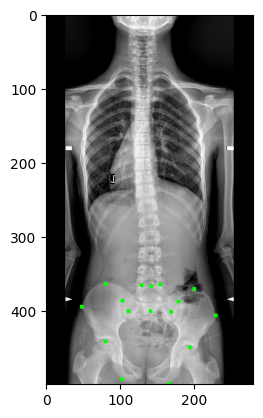

In [ ]:
rand_number = np.random.randint(0,len(val_df.dataframe))
X, Y = val_df.dataframe.loc[rand_number][-1:].item(),val_df.dataframe.loc[rand_number][0:32],
show_tran_image(X,Y)


Train Dataset Sample

In [ ]:
X_batch, y_batch= train_generator[0]


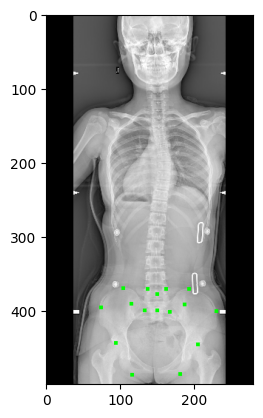

In [ ]:
rand_number = np.random.randint(0,len(X_batch))
X, Y = X_batch[rand_number],y_batch[rand_number][:32],
show_tran_image(X,Y)

Build Model

In [ ]:
model = tf.keras.models.Sequential()
pretrained_model = DenseNet121(input_shape=(height,width,3), include_top=False)
pretrained_model.trainable = True

model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))  #increase the number of neurons
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))  #increase the number of neurons
model.add(Dropout(0.2))
model.add(Dense(32))  # Yet another dense layer
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 15, 8, 1024)         │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 122880)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │     125,830,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │          16,416 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,408,864 (508.91 MB)

 Trainable params: 133,325,216 (508.60 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [ ]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
Adam=tf.keras.optimizers.Adam(learning_rate=1e-5, amsgrad=False)

model.compile(optimizer=Adam,loss='mean_squared_error',metrics=['mae'])

In [ ]:
epoch_num = 400

checkpoint_path = "/content/drive/MyDrive/Dataset/aspine20241201.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

model.load_weights(checkpoint_path)

# callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                          save_best_only=True,
                          save_freq='epoch',
                          save_weights_only=True,
                          verbose=1)

# callback that reduces learning rate when val_loss doesn't improve in 5 epoches
# reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.2, patience=3, min_lr=0.01)

history = model.fit(train_generator,
            validation_data=val_generator,
            epochs=epoch_num,
            callbacks=[cp_callback,])


Epoch 1/400
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - loss: 681.2950 - mae: 20.7982shuffle
shuffle

Epoch 1: val_loss improved from inf to 59.88000, saving model to /content/drive/MyDrive/Dataset/aspine20241201.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 679.6976 - mae: 20.7719 - val_loss: 59.8800 - val_mae: 6.0554
Epoch 2/400
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - loss: 611.8994 - mae: 19.7459shuffle
shuffle

Epoch 2: val_loss improved from 59.88000 to 45.77316, saving model to /content/drive/MyDrive/Dataset/aspine20241201.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 612.1179 - mae: 19.7489 - val_loss: 45.7732 - val_mae: 5.2616
Epoch 3/400
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - loss: 653.4141 - mae: 20.3739shuffle
shuffle

Epoch 3: val_loss improved from 45.77316 to 33.72350, saving model to /content/drive/MyDrive/Dataset/aspine20241201.weights.h5
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 656.0885 - mae: 20.4112 - val_loss: 33.7235 - val_mae: 4

KeyboardInterrupt: 

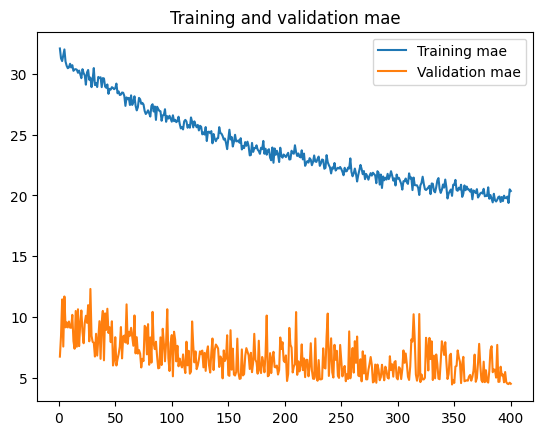

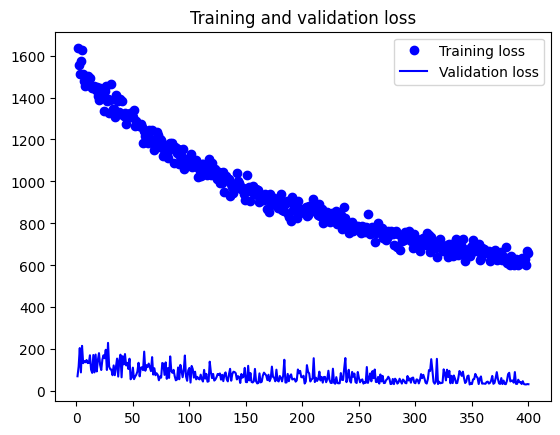

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(mae) + 1)

plt.plot(epochs, mae, label='Training mae')
plt.plot(epochs, val_mae, label='Validation mae')
plt.title('Training and validation mae')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
X_test, y_test= val_generator[0]
predictions = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


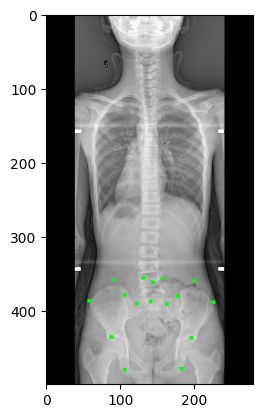

In [ ]:
index = np.random.randint(0,len(X_test))
#X, Y = X_test[index], predictions[index]
X, Y = X_test[index], predictions[index,:32]
show_tran_image(X,Y)

In [ ]:
model.save("/content/drive/MyDrive/Dataset/densenet121.h5")